In [1]:
import scanpy as sc

import pandas as pd
import numpy as np

import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib

import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import scipy
from scipy.stats import spearmanr
from scipy.stats import zscore
from scipy.stats import pearsonr
from sklearn.metrics import pairwise_distances

# utils function -- helper functions for plotting
import sys
sys.path.append('../../utils/')
import figure_utils as figure_utils

In [2]:
# %matplotlib inline
matplotlib.rcParams['figure.dpi'] = 2000 # 150 dpi resolution
matplotlib.rcParams['image.cmap'] = 'Spectral_r' # preferred color map
matplotlib.rcParams['figure.figsize'] = [6, 6] # Square

# no bounding boxes or axis:
matplotlib.rcParams['axes.spines.bottom'] = "off"
matplotlib.rcParams['axes.spines.top'] = "off"
matplotlib.rcParams['axes.spines.left'] = "off"
matplotlib.rcParams['axes.spines.right'] = "off"
%matplotlib inline

In [3]:
# UMAP PARAMS
DOT_SIZE = 25
LEGEND_FONTSIZE = 8
LEGEND_FONTOUTLINE = 1
UMAP_FIGSIZE = (20,20)

# SEXES COLOR -- NEW
HERM_COLOR = '#ff8b00'
MALE_COLOR = '#2258a5'
SHARED_SEX_COLOR = '#349c55'

# AXIS TICK COLORS
AXIS_TICK_COLORS = 'black'

# Sheath Socket Colors
SHEATH_COLOR = '#3ac9c9' # '#369e9e'
SOCKET_COLOR = '#c47841'

# COMPARTMENTS COLOR -- Non-neural, Coelomocyte, Glia, Neuron
COMPARTMENTS_COLOR = ['#c63287','#ff99da','#693996','#fdcd0f']

In [4]:
# load data
adata = sc.read('../../data/WholeData.h5ad')
adata_glia = sc.read('../../data/GliaOnly.h5ad')

# Figure 5A -- Hierarchical Clustering of Glia

In [5]:
# we perform hierarchical clustering at the PC level -- dimension of PC space for our analysis was 50
linkage, labels, paired_distances = figure_utils.compute_linkage(
    data_obsm=adata_glia.obsm['X_pca_harmony'],
    data_obs_index=adata_glia.obs_names,
    data_obs_label=adata_glia.obs['Cluster_Celltype'],
    feature_names=[f'PC{idx}' for idx in range(1,51)]
)

# ploting aesthetics related/color: color for the sex specificity + color for sheath/socket
# map the index (which are the Cluster_Celltype) to their sex specific labels from the anndata
sex_spec_map = dict(zip(
    adata_glia.obs['Cluster_Celltype'],
    adata_glia.obs['cluster_sex_label'].str.split('_').str.get(1)
))

# map the index to their specific glia types from the anndata
glia_map = dict(zip(
    adata_glia.obs['Cluster_Celltype'],
    adata_glia.obs['SheathSocket_label']
))

# assign the colors to sexes
color_sex = paired_distances.columns.map(sex_spec_map).map({
    'Both':SHARED_SEX_COLOR,
    'Male':MALE_COLOR,
    'Herm':HERM_COLOR 
})

# asssign the colors to sheath and socket 
color_glia = paired_distances.columns.map(glia_map).map({
    'Sheath':SHEATH_COLOR,
    'Socket':SOCKET_COLOR
})

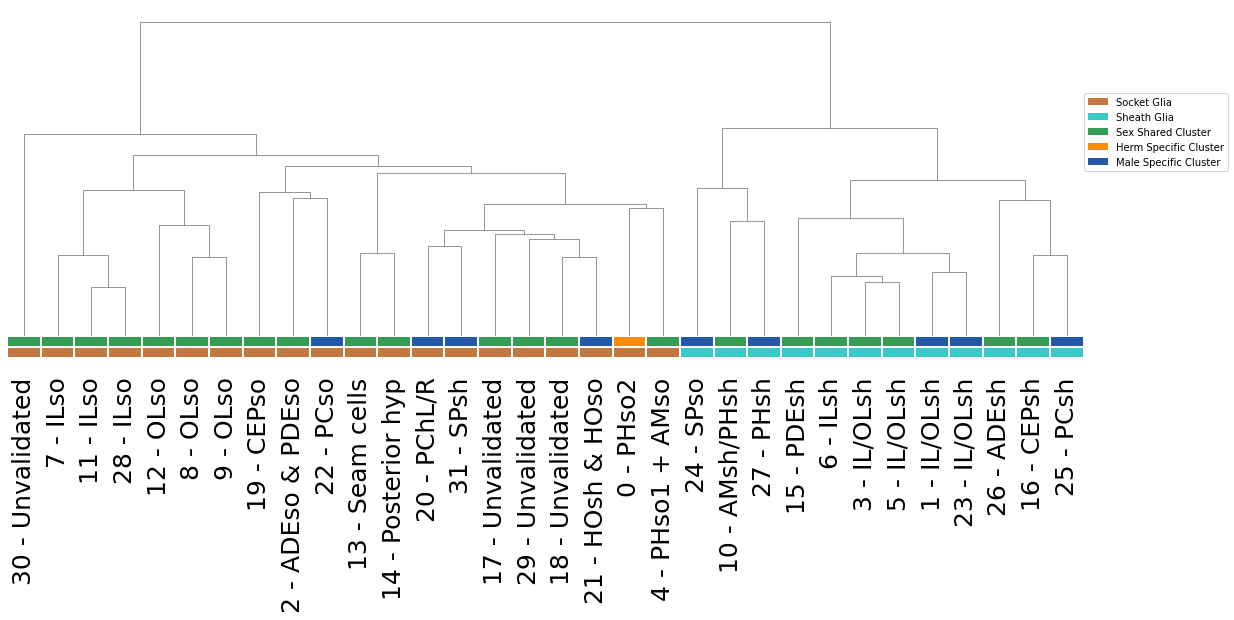

In [6]:
# plot the dendrogram -- plotted using the clustermap
dendrogram = sns.clustermap(
    1 - paired_distances,
    xticklabels=paired_distances.index,
    col_colors=[color_sex,color_glia],
    yticklabels=False,
    figsize=(150,7),  
    linewidth=0.05,
    dendrogram_ratio=(0.9,0.9), # can just be done through illustrator
    cmap='RdBu_r',
    cbar_pos=None,
#     col_linkage=linkage # the computed linkage is also the same default clustering that seaborn does
)

# hide the row dendorgrams on clustermap
dendrogram.ax_row_dendrogram.set_visible(False)

# legends for the dendrogram
dendrogram.ax_col_dendrogram.bar(0,0, color=SOCKET_COLOR, label='Socket Glia', linewidth=0)
dendrogram.ax_col_dendrogram.bar(0,0, color=SHEATH_COLOR, label='Sheath Glia', linewidth=0)
dendrogram.ax_col_dendrogram.bar(0,0, color=SHARED_SEX_COLOR, label='Sex Shared Cluster', linewidth=0)
dendrogram.ax_col_dendrogram.bar(0,0, color=HERM_COLOR, label='Herm Specific Cluster', linewidth=0)
dendrogram.ax_col_dendrogram.bar(0,0, color=MALE_COLOR, label='Male Specific Cluster', linewidth=0)
# dendrogram.ax_col_dendrogram.legend(loc="upper right", ncol=1, title='')
dendrogram.ax_col_dendrogram.legend(loc=(1,0.5), ncol=1, title='')


# hide the labels on the axes
dendrogram.ax_heatmap.set_xlabel('')
dendrogram.ax_heatmap.set_ylabel('')
dendrogram.ax_heatmap.set_yticklabels('')

# tick size fonts
dendrogram.ax_heatmap.set_xticklabels(dendrogram.ax_heatmap.get_xmajorticklabels(), fontsize = 25)
dendrogram.ax_heatmap.axes.tick_params(axis='both', which='both', length=0.01)
dendrogram.savefig('figures/figure_5A_HierarchicalClustering.png')

# hide the y-axis labels
plt.show()

# Figure 5A -- Sheath & Socket Glia UMAP

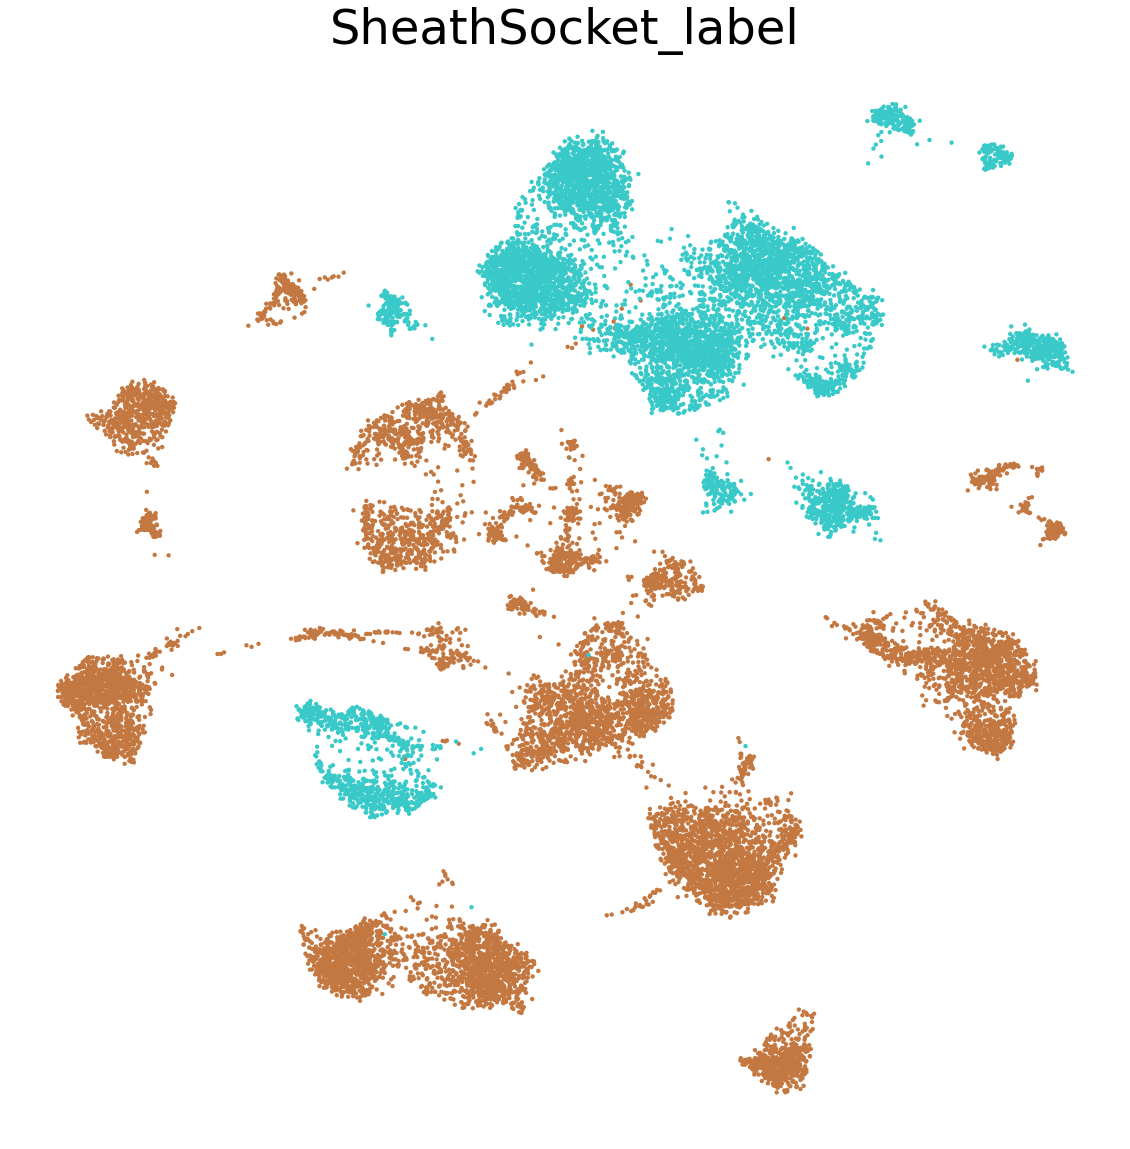

In [7]:
with matplotlib.pyplot.rc_context({'figure.figsize':UMAP_FIGSIZE,'font.size':40.0}):
    sc.pl.umap(
        adata_glia,
        color='SheathSocket_label',
        frameon=False,
        size=DOT_SIZE + 52,
        legend_loc=None,
        save='figure_5A_SheathSocket_label.png'
    )

# Figure 5B -- Identified Sheath & Socket Glial Markers

In [8]:
# get the identified markers stored in the data
shso_marker = {
    'Socket': adata_glia.uns['FiguresData_Socket_Selection_Results']['Identified_Genes'][:7],
    'Sheath': adata_glia.uns['FiguresData_Sheath_Selection_Results']['Identified_Genes'][:7]
}

categories: 0 - PHso2, 1 - IL/OLsh, 10 - AMsh/PHsh, etc.
var_group_labels: Socket, Sheath


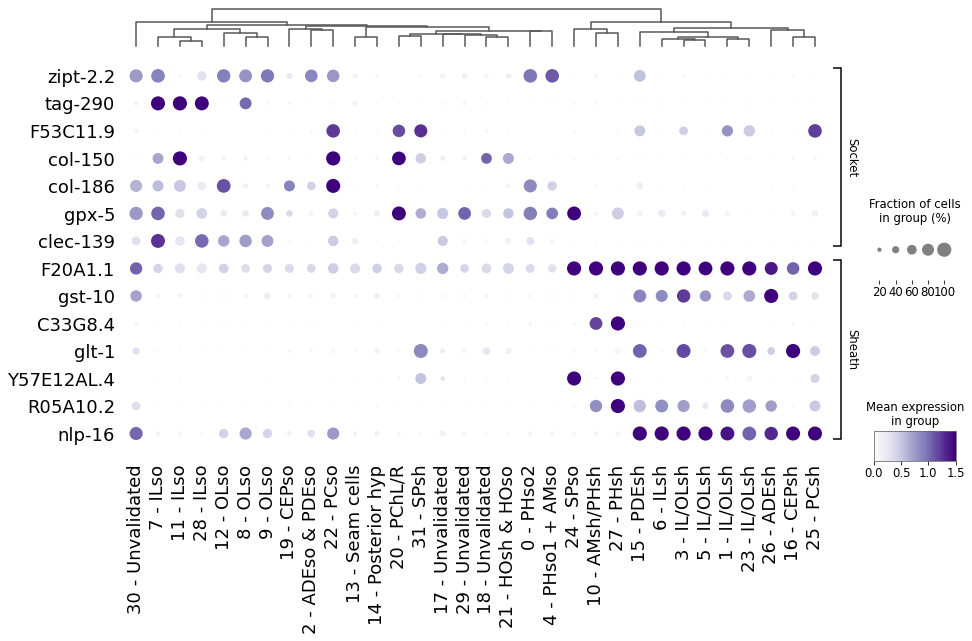

In [9]:
with matplotlib.pyplot.rc_context({'axes.edgecolor':'dimgray', 'xtick.color':AXIS_TICK_COLORS, 'ytick.color':AXIS_TICK_COLORS, 'figure.facecolor':'white','font.size':14}):
    dotplot = sc.pl.dotplot(adata_glia, var_names=shso_marker, groupby='Cluster_Celltype', cmap='Purples', 
                            return_fig=True, dendrogram=True, swap_axes=True, figsize=(15,8), vmin=0, vmax=1.5)
    dotplot.dot_edge_lw = 0.01
    
    # fix aesthetics
    dotplot.get_axes()['mainplot_ax'].axes.tick_params(axis='both', which='both', length=0.01)
    
    # axis fonts/colors
    xticks = dotplot.get_axes()['mainplot_ax'].axes.get_xticklabels()
    yticks = dotplot.get_axes()['mainplot_ax'].axes.get_yticklabels()
    
    for tick in xticks:
        tick.set_fontsize(18)
        # tick.set_color
    
    for tick in yticks:
        tick.set_fontsize(18)
    
    # save
    plt.savefig('figures/figure_5B_SheathSocketMarkers_Dotplot.png')

# Figure 5F -- Sheath Minimal Set, 2 Genes

In [10]:
# get the results
minimalset_results = adata_glia.uns['FiguresData_Sheath_Selection_Results']['Minimal_Set_Results'].copy()

# get the 2 gene combinations
minimalset_results = minimalset_results.loc[minimalset_results['min_set_label'] == '2_genes',:]

In [11]:
# plot and color by sex of the clusters -- sort
order = minimalset_results.groupby('combination').var() \
            .rename(columns={'mean_probability_estimates':'median_of_means'}) \
            .sort_values(by='median_of_means', ascending=True).index

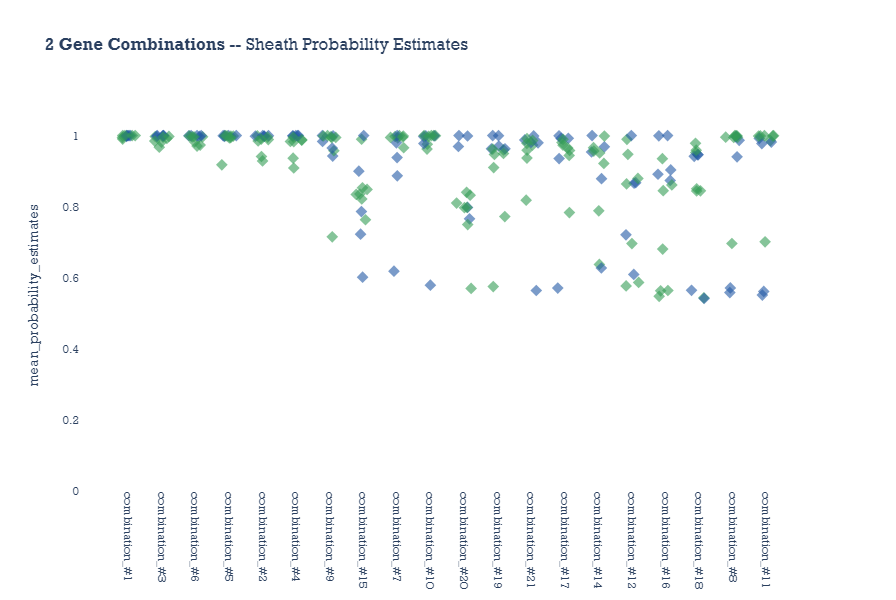

In [12]:
def add_scatter_trace(fig, df, label, y_offset):
    df_label = df[df['combination'] == label]
    fig.add_trace(go.Scatter(
        # x=y_offset + np.random.rand(len(df_label)) * 0.4,  # Adding jitter to x-values
        x = y_offset + np.random.uniform(low=-0.5, high=0.5, size=len(df_label)) * 0.45, # much better implementation of jitter
        y=df_label['mean_probability_estimates'],  # Y-values are the mean_probability_estimates
        mode='markers',
        marker=dict(
            size=9,
            symbol='diamond',
            color=df_label['sex_colors'],
            opacity=0.6,
        ),
        name=label,
        text=df_label['cluster']
    ))

fig = go.Figure()

# take the first 20 combinations
unique_labels = minimalset_results.groupby('combination').var() \
            .rename(columns={'mean_probability_estimates':'median_of_means'}) \
            .sort_values(by='median_of_means', ascending=True).index[:20]

N = len(minimalset_results)
y_offsets = np.arange(len(unique_labels))

for label, y_offset in zip(unique_labels, y_offsets):
    add_scatter_trace(fig, minimalset_results, label, y_offset)

fig.update_layout(showlegend=False, coloraxis_showscale=False, plot_bgcolor='rgba(0,0,0,0)', width=1200,
                  height=600, title='<b>2 Gene Combinations</b> -- Sheath Probability Estimates', font=dict(family='Rockwell'))
fig.update_traces(marker_showscale=False)
fig.update_yaxes(title='mean_probability_estimates', range=[0,1.1])  # Update y-axis title & set the range
fig.update_xaxes(tickvals=y_offsets, ticktext=unique_labels, tickangle=90)
fig.write_image('figures/figure_5F_Sheath_2-GeneCombination_Probability_Estimates_top20Combo.png')
fig.write_html('figures/figure_5F_Sheath_2-GeneCombination_Probability_Estimates_top20Combo.html')
fig.show()

In [13]:
# get the results
minimalset_results = adata_glia.uns['FiguresData_Sheath_Selection_Results']['Minimal_Set_Results'].copy()

# get the 2 gene combinations
minimalset_results = minimalset_results.loc[minimalset_results['min_set_label'] == '2_genes',:]

# get the combination -- combination_#1
minimal_combo = minimalset_results.loc[minimalset_results['combination'] == 'combination_#1','gene_combo'].unique().item()

# markers
markers = minimal_combo.replace("(", "").replace(")", "").replace('\'',"").split(', ')

In [14]:
sheath_select_combo

NameError: name 'sheath_select_combo' is not defined

In [15]:
sheath_opt_minimal = minimalset_results.loc[minimalset_results['combination'] == 'combination_#1','gene_combo'].unique().item()
sheath_opt_minimal = sheath_opt_minimal.replace("(", "").replace(")", "").replace('\'',"").split(', ')

# Figure 5G -- Socket Minimal Set, 2 Genes

In [16]:
# get the results
minimalset_results = adata_glia.uns['FiguresData_Socket_Selection_Results']['Minimal_Set_Results'].copy()

# get the 2 gene combinations
minimalset_results = minimalset_results.loc[minimalset_results['min_set_label'] == '2_genes',:]

In [17]:
# plot and color by sex of the clusters -- sort
order = minimalset_results.groupby('combination').var() \
            .rename(columns={'mean_probability_estimates':'median_of_means'}) \
            .sort_values(by='median_of_means', ascending=True).index

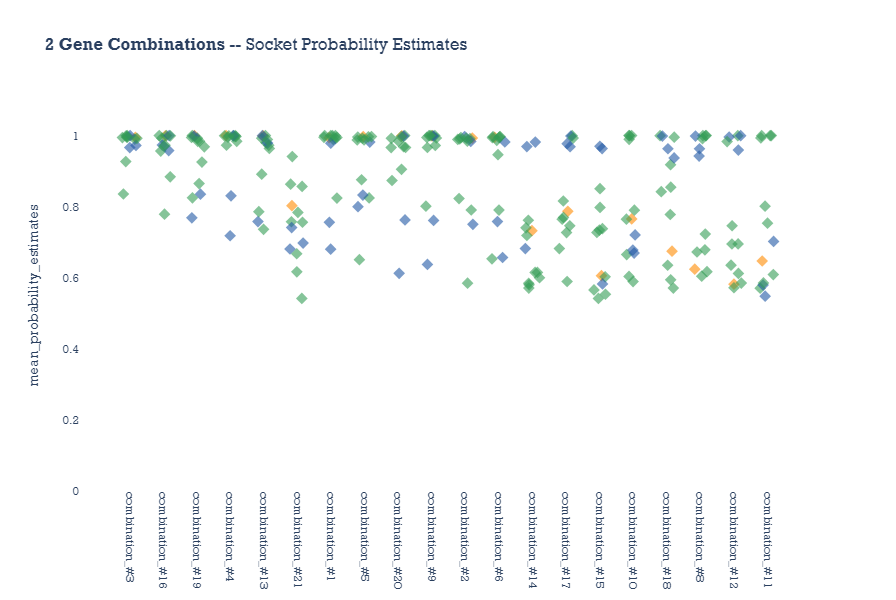

In [18]:
def add_scatter_trace(fig, df, label, y_offset):
    df_label = df[df['combination'] == label]
    fig.add_trace(go.Scatter(
        # x=y_offset + np.random.rand(len(df_label)) * 0.4,  # Adding jitter to x-values
        x = y_offset + np.random.uniform(low=-0.5, high=0.5, size=len(df_label)) * 0.45, # much better implementation of jitter
        y=df_label['mean_probability_estimates'],  # Y-values are the mean_probability_estimates
        mode='markers',
        marker=dict(
            size=9,
            symbol='diamond',
            color=df_label['sex_colors'],
            opacity=0.6,
        ),
        name=label,
        text=df_label['cluster']
    ))

fig = go.Figure()

# take the first 20 combinations
unique_labels = minimalset_results.groupby('combination').var() \
            .rename(columns={'mean_probability_estimates':'median_of_means'}) \
            .sort_values(by='median_of_means', ascending=True).index[:20]

N = len(minimalset_results)
y_offsets = np.arange(len(unique_labels))

for label, y_offset in zip(unique_labels, y_offsets):
    add_scatter_trace(fig, minimalset_results, label, y_offset)

fig.update_layout(showlegend=False, coloraxis_showscale=False, plot_bgcolor='rgba(0,0,0,0)', width=1200,
                  height=600, title='<b>2 Gene Combinations</b> -- Socket Probability Estimates', font=dict(family='Rockwell'))
fig.update_traces(marker_showscale=False)
fig.update_yaxes(title='mean_probability_estimates', range=[0,1.1])  # Update y-axis title & set the range
fig.update_xaxes(tickvals=y_offsets, ticktext=unique_labels, tickangle=90)
fig.write_image('figures/figure_5G_Socket_2-GeneCombination_Probability_Estimates_top20Combo.png')
fig.write_html('figures/figure_5G_Socket_2-GeneCombination_Probability_Estimates_top20Combo.html')
fig.show()

# Figure 5G -- Socket Minimal Set, 3 Genes

In [19]:
# get the results
minimalset_results = adata_glia.uns['FiguresData_Socket_Selection_Results']['Minimal_Set_Results'].copy()

# get the 3 gene combinations
minimalset_results = minimalset_results.loc[minimalset_results['min_set_label'] == '3_genes',:]

In [20]:
# plot and color by sex of the clusters -- sort
order = minimalset_results.groupby('combination').var() \
            .rename(columns={'mean_probability_estimates':'median_of_means'}) \
            .sort_values(by='median_of_means', ascending=True).index

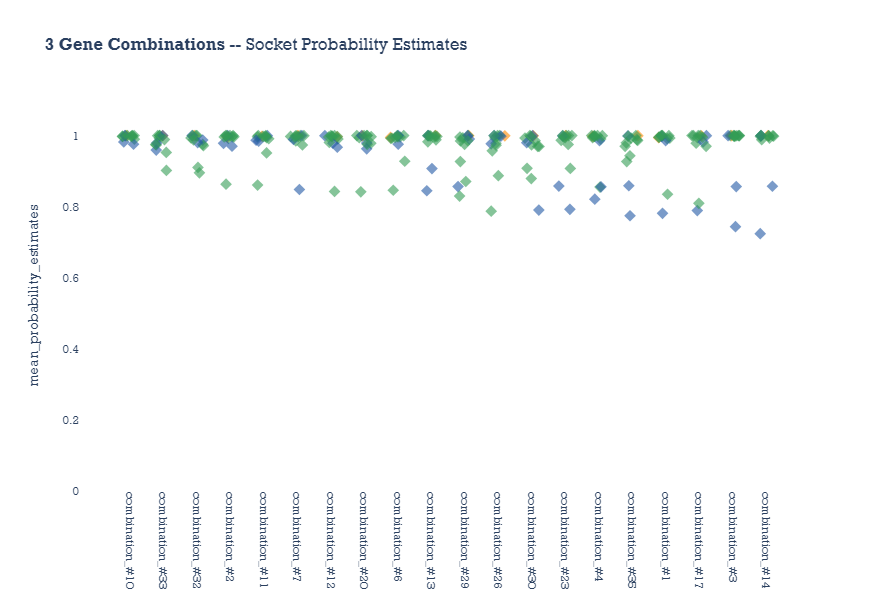

In [21]:
def add_scatter_trace(fig, df, label, y_offset):
    df_label = df[df['combination'] == label]
    fig.add_trace(go.Scatter(
        # x=y_offset + np.random.rand(len(df_label)) * 0.4,  # Adding jitter to x-values
        x = y_offset + np.random.uniform(low=-0.5, high=0.5, size=len(df_label)) * 0.45, # much better implementation of jitter
        y=df_label['mean_probability_estimates'],  # Y-values are the mean_probability_estimates
        mode='markers',
        marker=dict(
            size=9,
            symbol='diamond',
            color=df_label['sex_colors'],
            opacity=0.6,
        ),
        name=label,
        text=df_label['cluster']
    ))

fig = go.Figure()

# take the first 20 combinations
unique_labels = minimalset_results.groupby('combination').var() \
            .rename(columns={'mean_probability_estimates':'median_of_means'}) \
            .sort_values(by='median_of_means', ascending=True).index[:20]

N = len(minimalset_results)
y_offsets = np.arange(len(unique_labels))

for label, y_offset in zip(unique_labels, y_offsets):
    add_scatter_trace(fig, minimalset_results, label, y_offset)

fig.update_layout(showlegend=False, coloraxis_showscale=False, plot_bgcolor='rgba(0,0,0,0)', width=1200,
                  height=600, title='<b>3 Gene Combinations</b> -- Socket Probability Estimates', font=dict(family='Rockwell'))
fig.update_traces(marker_showscale=False)
fig.update_yaxes(title='mean_probability_estimates', range=[0,1.1])  # Update y-axis title & set the range
fig.update_xaxes(tickvals=y_offsets, ticktext=unique_labels, tickangle=90)
fig.write_image('figures/figure_5G_Socket_3-GeneCombination_Probability_Estimates_top20Combo.png')
fig.write_html('figures/figure_5G_Socket_3-GeneCombination_Probability_Estimates_top20Combo.html')
fig.show()

In [22]:
socket_opt_minimal = minimalset_results.loc[minimalset_results['combination'] == 'combination_#10','gene_combo'].unique().item()
socket_opt_minimal = socket_opt_minimal.replace("(", "").replace(")", "").replace('\'',"").split(', ')

## Figure 5F/G -- Sheath/Socket, Minimal Optimal Set

In [23]:
optimal_sets = {
    'Socket': socket_opt_minimal,
    'Sheath': sheath_opt_minimal
}

categories: 0 - PHso2, 1 - IL/OLsh, 10 - AMsh/PHsh, etc.
var_group_labels: Socket, Sheath


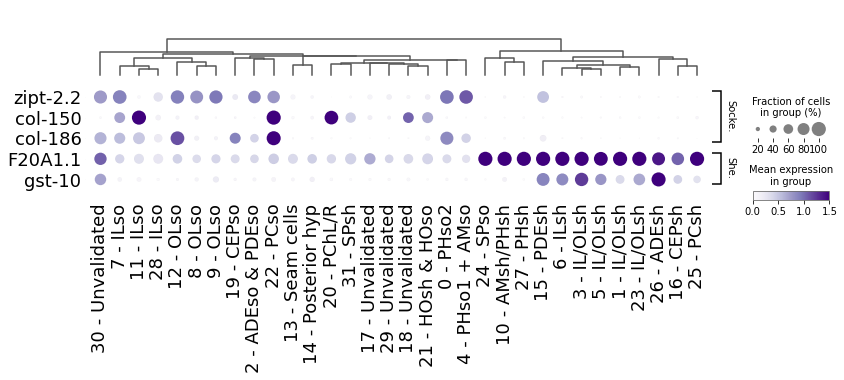

In [24]:
with matplotlib.pyplot.rc_context({'axes.edgecolor':'dimgray', 'xtick.color':AXIS_TICK_COLORS, 'ytick.color':AXIS_TICK_COLORS, 'figure.facecolor':'white','font.size':12}):
    dotplot = sc.pl.dotplot(adata_glia, var_names=optimal_sets, groupby='Cluster_Celltype', cmap='Purples', 
                            return_fig=True, dendrogram=True, swap_axes=True, vmin=0, vmax=1.5)
    dotplot.dot_edge_lw = 0.01
    
    # fix aesthetics
    dotplot.get_axes()['mainplot_ax'].axes.tick_params(axis='both', which='both', length=0.01)
    
    # axis fonts/colors
    xticks = dotplot.get_axes()['mainplot_ax'].axes.get_xticklabels()
    yticks = dotplot.get_axes()['mainplot_ax'].axes.get_yticklabels()
    
    for tick in xticks:
        tick.set_fontsize(18)
        # tick.set_color
    
    for tick in yticks:
        tick.set_fontsize(18)
    
    # save
    plt.savefig('figures/figure_5FG_SheathSocket_SelectOptimalSet_Dotplot.png')